In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from gp import *

In [5]:
hyperparameters = {"b":1, "tau_sq_1": 1, "tau_sq_2": 1}
x = np.linspace(0,1,100)

In [41]:
cov_matrix = np.zeros([len(x), len(x)])
cov_matrix[0,0]
cov_func = squared_exponential_cov
cov_matrix[0,0] = cov_func(x[0], x[0], hyperparameters)

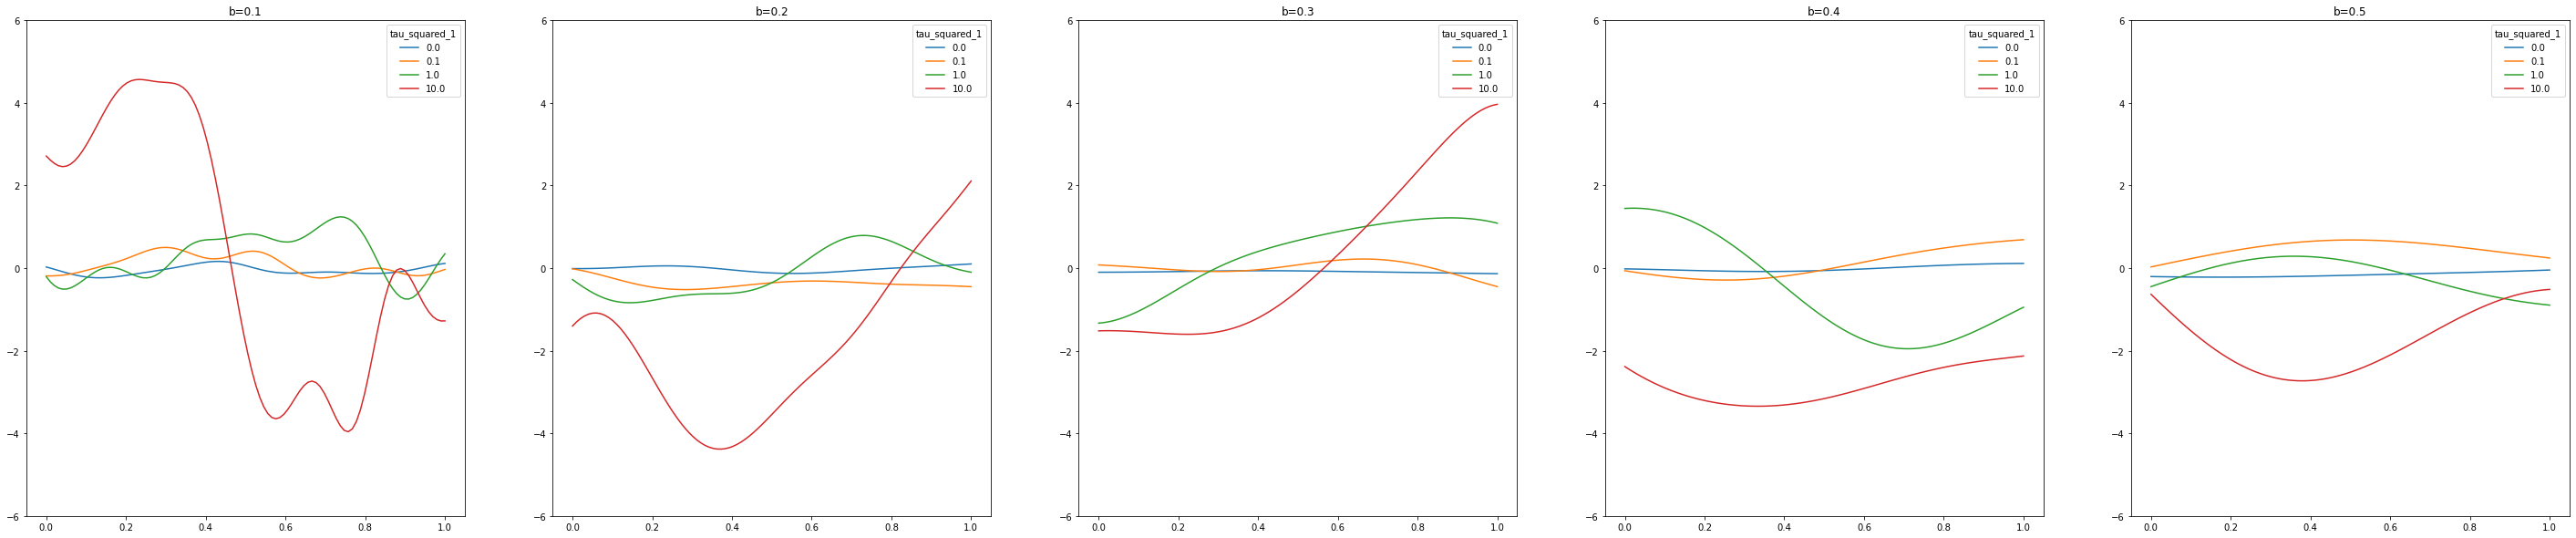

In [120]:
b = np.linspace(.1,.5,5)
t1 = np.array([.01,.1,1, 10])
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_1": t1[j], "tau_sq_2": 0}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, squared_exponential_cov, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_1"], 1)))
        ax.legend(title="tau_squared_1")
        ax.set_ylim(-6,6)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

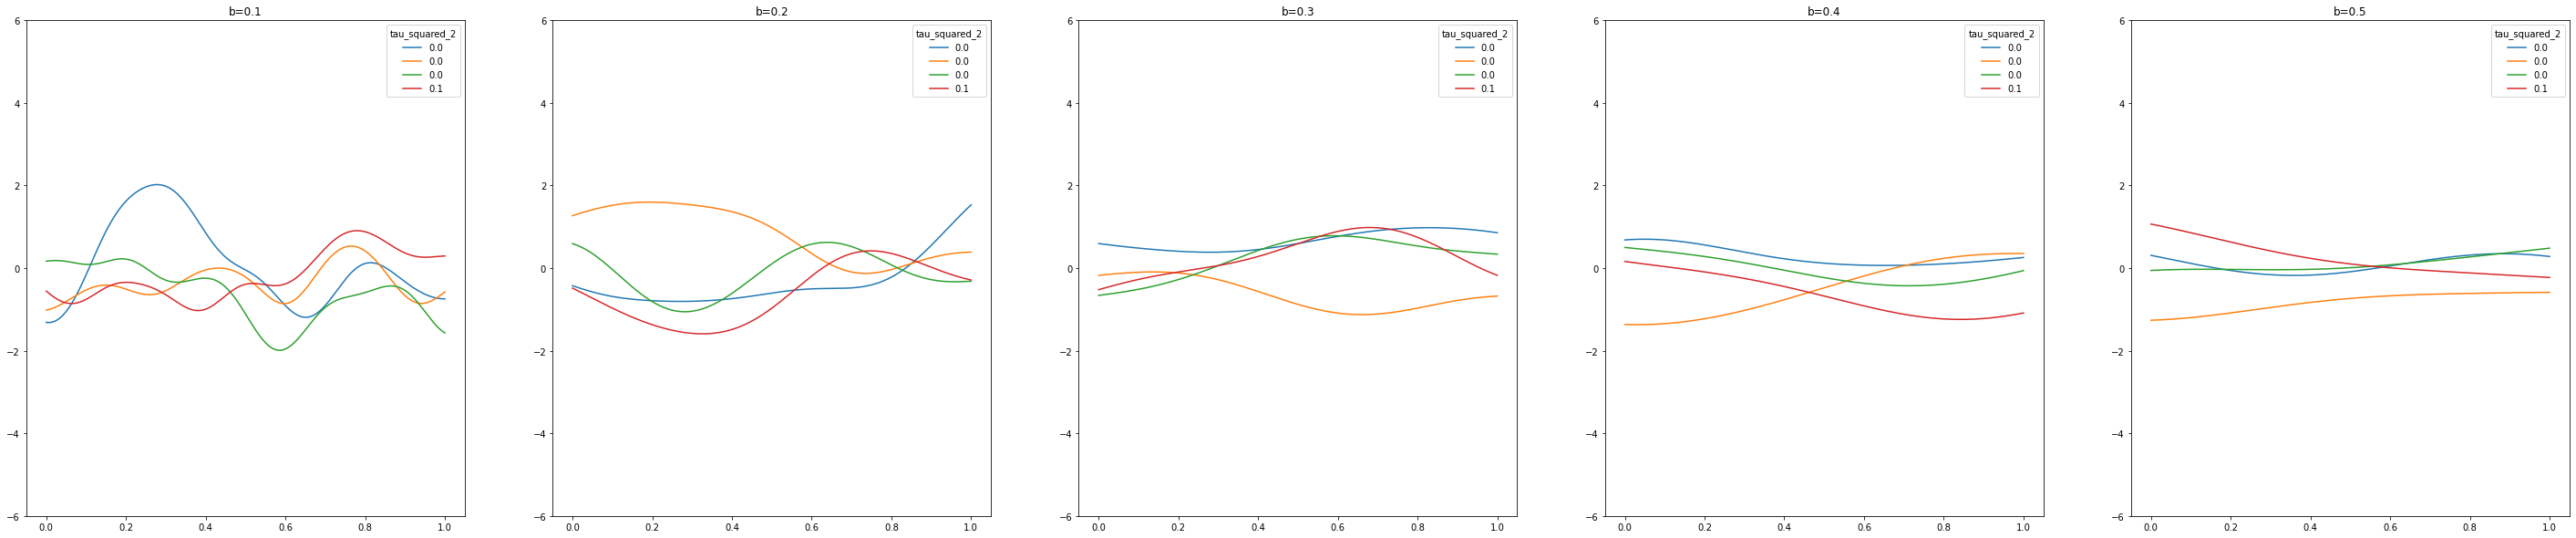

In [125]:
b = np.linspace(.1,.5,5)
x=np.linspace(0,1,500)
t2 = np.array([.00001, .0001, .01, .1])
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_2": t2[j], "tau_sq_1": .5}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, squared_exponential_cov, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_2"], 1)))
        ax.legend(title="tau_squared_2")
        ax.set_ylim(-6,6)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

KeyboardInterrupt: 

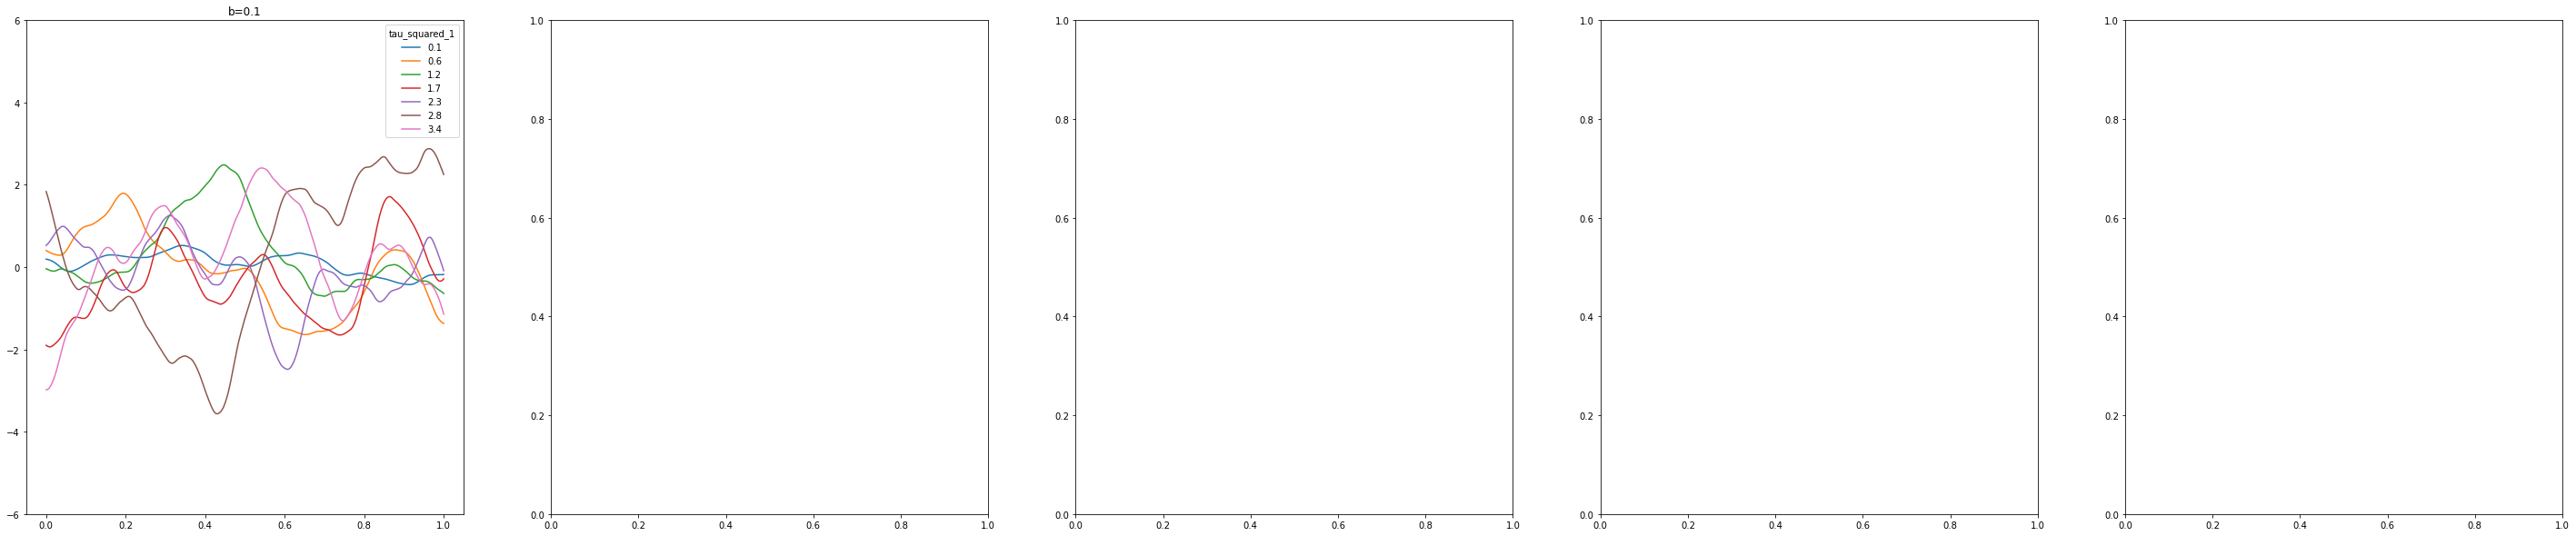

In [104]:
b = np.linspace(.1,.5,5)
t1 = np.linspace(.1,5,10)
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_1": t1[j], "tau_sq_2": 10**-6}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, matern_5_2, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_1"], 1)))
        ax.legend(title="tau_squared_1")
        ax.set_ylim(-6,6)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

In [9]:
def plot_gp(x, hyperparameters, cov_func):
    y = gaussian_process(x, cov_func, hyperparameters)
    plt.plot(x,y, label=str(round(hyperparameters["tau_sq_1"], 1)))
    plt.legend(title="tau_squared_1")
    plt.title("b=" + str(round(hyperparameters["b"],1)))



In [10]:
hyperparameters = {"b":.4, "tau_sq_1": 4, "tau_sq_2": 0}
x=np.linspace(0,1,500)
plot_gp(x, hyperparameters, squared_exponential_cov)

ValueError: maximum supported dimension for an ndarray is 32, found 501